[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Overplanting within the PECD

This notebook provides a practical introduction to overplanting, in particular for solar photovoltaics (SPV), and its impact to the handling of the Pan-European Climate Database version 4.2 ([PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) data.

**The tutorial will demonstrate how overplanting impacts the analysis and processing of installed capacity (IC) and capacity factor (CF) data**. By clarifying some IC-related elements, it can also contribute to a clearer and more objective interaction with ENTSO-E's data collection for to the Pan-European Market Modelling Database (PEMMDB).

In this example, we will download and read aggregated NUTS2 data in CSV format for utility-scale fixed PV in 2020 / historical stream.

## Learning objectives 🧠

In this notebook, you will learn about overplanting and its trends. You will also understand how a misuse of IC data can impact your data analysis. Finally, you will see how to properly process your PECD4.2 CF data.

## Target Audience 🎯

**Anyone** interested in learning about overplanting and how to deal with relevant PECD4.2 data.

## Some theory first 📖

### SPV installed capacity (IC)


Solar photovoltaics generates its electricity in direct current (DC) and needs an inverter to work as an interface with the grid connection point. In practice, a SPV project is fully characterized by three installed capacities: i) the modules capacity for the DC side; ii) the inverter capacity for its AC output; and iii) the injection capacity of the grid connection point.

Thus, while the DC capacity drives SPV generation overall, the lowest of the AC values defines the maximum grid injection.

![pvcap_plot](img/overplanting/pvcap_plot.png)

### Overplanting and computing Capacity Factors 
Overplanting, also known as inverter loading, consists of an engineering design strategy where the IC of the PV modules (DC) intentionally surpass by a given margin its AC-counterpart. Traditionally, this has a financial motivation, e.g. a proportionally smaller inverter will be cheaper, but more and more it is being considered in local grid regulations. At the cost of some clipping, with the inverter saturating its output power whenever the DC output exceeds the nominal AC rate, developers can increase the overall revenue and/or have their projects be grid-compliant.

![overplanting_plot](img/overplanting/overplanting_plot.png)

Example of overplanting and resulting inverter saturation whenever the DC output surpasses the inverter nominal capacity.

Being CF calculated using the equation below, **it is important to discuss about which IC to consider**. 

$$ CF_{PV} =\frac{PV power}{IC}  $$


> **Note on SPV capacity factor (CF) within PECD**  
>PECD3.1 calculated CF using the $IC_{AC}$ with a constant 1.1 overplanting factor. Since PECDv4.1, we use instead the $IC_{DC}$, asking end-users for custom overplanting factors. This allows for the assumptions on overplanting to be made ad-hoc and a-posteriori using simple postprocessing, as well as helps highlight the need to consider properly the IC used.

## Prepare your environment

### Import libraries

In the following we will import five libraries: the [os](https://docs.python.org/3/library/os.html) module provides functions to interact with the operating system, especially for file and directory operations. It allows the script to build portable file paths, list contents of folders, or check if files exist. The [pandas](https://pandas.pydata.org/docs/) module provides a way to read, handle, and visualize tabular data; the [numpy](https://numpy.org/doc/stable) module is here used to generate sequence of float values; and the [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module allows us to generate and edit standard visualizations. [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) is a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing you to download the needed data for this work.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes, like ```"your_api_key"```). Your token can be found on the CDS portal at: https://cds.climate.copernicus.eu/profile (you will need to log in to view your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

The data can be downloaded from the PECD CDS download form, by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be copied and pasted directly into a cell of your Jupyter Notebook. This step has already been done for you in the cell below, but if you'd like to try it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example, we use data from PECD version “PECD4.2” for the “Historical” temporal stream, derived from ERA5 reanalysis. The selected variable is the “solar photovoltaic generation capacity factor”, retrieved for the year 2020 at "NUTS 2" spatial resolution and covering the photovoltaic technology "62 (SPV utility-scale fixed)", i.e. large, ground-based installations with fixed Si modules.

The API request reflecting these selections is shown in the next cell.

In [3]:
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "technology": ["62"],
    "spatial_resolution": ["nuts_2"],
    "year": ["2020"],
    "variable": ["solar_photovoltaic_generation_capacity_factor"],
}

Before running the download we can make sure there is a dedicated folder ready to host the data.

In [2]:
input_dir = "cds_data/overplanting/"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [5]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/data.zip")

2025-07-11 13:09:34,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-11 13:09:40,969 INFO Request ID is a40881e3-8781-4279-a1aa-cd4d8286b021
2025-07-11 13:09:41,036 INFO status has been updated to accepted
2025-07-11 13:09:49,600 INFO status has been updated to running
2025-07-11 13:09:54,700 INFO status has been updated to successful


ece74e120d28b76d46ada2e04ab76a02.zip:   0%|          | 0.00/8.01M [00:00<?, ?B/s]

'cds_data/overplanting//data.zip'

Since our data are inside zipped files we need to unzip them. The final CSV file will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the PECD.

In [6]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {input_dir}/{fname} -d {input_dir}")

Archive:  cds_data/overplanting//data.zip


replace cds_data/overplanting/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Read PECD NUTS2-level capacity factor
Let's inspect our data choosing Spain as an arbitrary sunny example.

In [3]:
# spv_utility_fix, 2020 (as an example)
filename = (
    "H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_"
    "S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_"
    "62_NA---_NA---_PhM03_PECD4.2_fv1.csv"
)

df = pd.read_csv(
    input_dir + filename, comment="#", delimiter=",", index_col=["Date"], parse_dates=["Date"]
)
print(df.iloc[:8, 7:12])

                        AL01    AL02     AL03     AT11  AT12
Date                                                        
2020-01-01 00:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 01:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 02:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 03:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 04:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 05:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 06:00:00  0.00000  0.0000  0.00000  0.00000   0.0
2020-01-01 07:00:00  0.03103  0.0423  0.04922  0.00002   0.0


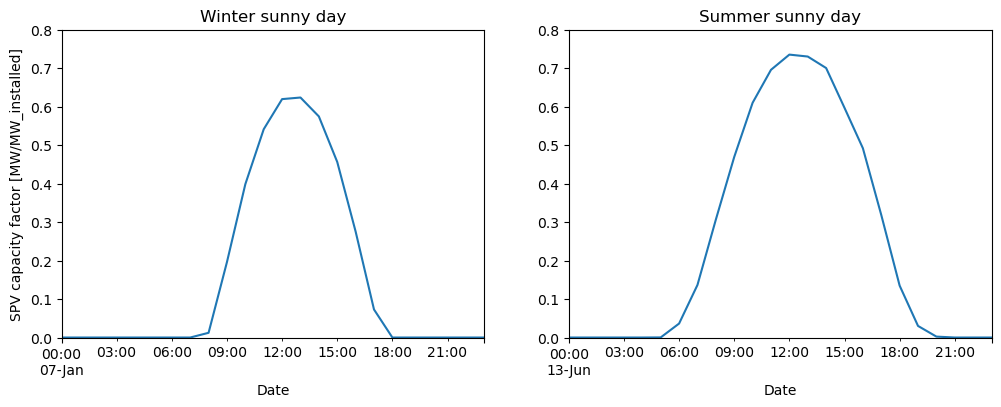

In [4]:
region_to_plot = "ES62"  # Murcia, south of Spain, as an example (sunny location)
df2 = df[region_to_plot]

# plotting side by side a winter and a summer day
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df2["2020-01-07"].plot(ax=ax1)
df2["2020-06-13"].plot(ax=ax2)

ax1.set_title("Winter sunny day")
ax1.set_ylabel("SPV capacity factor [MW/MW_installed]")
ax1.set_ylim([0, 0.8])
ax2.set_title("Summer sunny day")
ax2.set_ylim([0, 0.8])

plt.show()

### CF units and IC data

As you see can in the units of the y-axis in the left plot above, the SPV capacity factor is computed in MW/MW_installed. As mentioned before, **PECDv4.1 and v4.2 compute $CF_{PV}$ considering the $IC_{DC}$ (i.e. the "MW_installed" refers to the modules)**.

Therefore, converting between capacity factor and PV generation **using directly the $IC_{AC}$ can lead to unintentional deviations**.

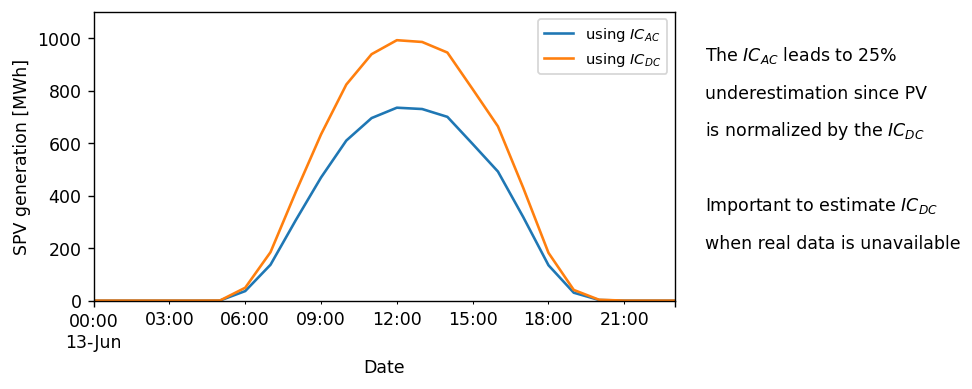

In [5]:
# example: TSO only has AC-level IC data, while overplanting in place is 1.35
# (this value could be a likely upper bound for utility-scale installations)
overplanting = 1.35
ic_ac = 1000  # installed capacity, 1 GW as example
ic_dc = ic_ac * overplanting  # GWp, peak DC module capacity

fig, ax1 = plt.subplots(1, 1, figsize=(6, 3), dpi=125)
(df2["2020-06-13"] * ic_ac).plot(ax=ax1)
(df2["2020-06-13"] * ic_dc).plot(ax=ax1)
ax1.set_ylim([0, 1100])
ax1.set_ylabel("SPV generation [MWh]")
ax1.legend(["using $IC_{}$".format("{AC}"), "using $IC_{}$".format("{DC}")], fontsize=8.5)

underestimate = int((1 - 1 / overplanting) * 100)
textstr = [
    "The $IC_{}$ leads to {}%".format("{AC}", underestimate),
    "underestimation since PV",
    "is normalized by the $IC_{}$".format("{DC}"),
]
for k in range(0, 3):
    plt.text(0.94, 0.75 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = ["Important to estimate $IC_{}$".format("{DC}"), "when real data is unavailable"]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

**When only $IC_{AC}$ is available, it is crucial to estimate the corresponding $IC_{DC}$**. For PECDv4.2, **we propose the following values** (c.f. section "Contextual information" below):
- residential rooftop: 1.05-1.1
- industrial rooftop: 1.15-1.2
- utility fixed and tracking: 1.2-1.35

Conversely, **if you normalize generation data** using the $IC_{AC}$, you will be overestimating your data since it will not match with the convention assumed within PECD SPV data.

### Accounting for clipping losses

#### A first example

We now need to take account for inverter saturation (also known as clipping losses). In essence, the PV output is capped whenever its DC output surpasses the inverter AC nominal rate.

From a CF perspective, the effective output can never surpass `AC/DC ratio`, which is the inverse of the overplanting factor.

$$ CF' = min(CF,\frac{IC_{AC}}{IC_{DC}}) = min(CF,\frac{1}{\frac{IC_{DC}}{IC_{AC}}})$$

Picking on the previous example, an overplanting of 1.35 means that the effective SPV CF can never surpass 0.74 (1/1.35).

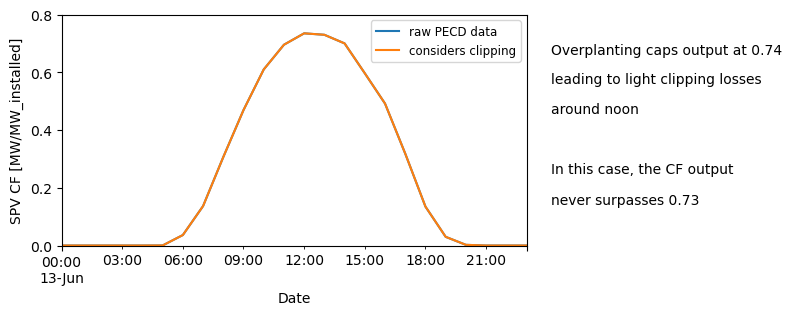

In [6]:
# Using pandas, we can use the clip() functions that defines the min and
# max values for the dataframe
df3 = df2.clip(0, 1 / overplanting)

ax1 = df2["2020-06-13"].plot(figsize=(6, 3))
df3["2020-06-13"].plot()

ax1.set_ylim([0, 0.8])
ax1.set_yticks(np.arange(0, 1, 0.2))
ax1.set_ylabel("SPV CF [MW/MW_installed]")
ax1.legend(["raw PECD data", "considers clipping"], fontsize=8.5)

value = round(1 / overplanting, 2)
textstr = [
    "Overplanting caps output at {}".format(value),
    "leading to light clipping losses",
    "around noon",
]
for k in range(0, 3):
    plt.text(0.94, 0.75 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = [
    "In this case, the CF output",
    "never surpasses {}".format(df2["2020-06-13"].round(2).max()),
]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

> **Note on ERA5-based clipping losses**
> It has been documented how [hourly data underestimates clipping losses due to temporal smoothing](https://pubs.aip.org/aip/jrse/article/14/6/063503/2848734/The-effect-of-short-term-inverter-saturation-on), which can be amplified by ERA5's coarser resolution (even more if spatially aggregated).
> Thus, we suggest that this processing is done ideally using gridded data before further aggregating in space.
> A future release of PECD may account for the underestimation due to the temporal averaging.

#### A second example

For the sake of illustration, we assume a much higher overplanting of 2 where the effective SPV CF can never surpass 0.5 (1/2).

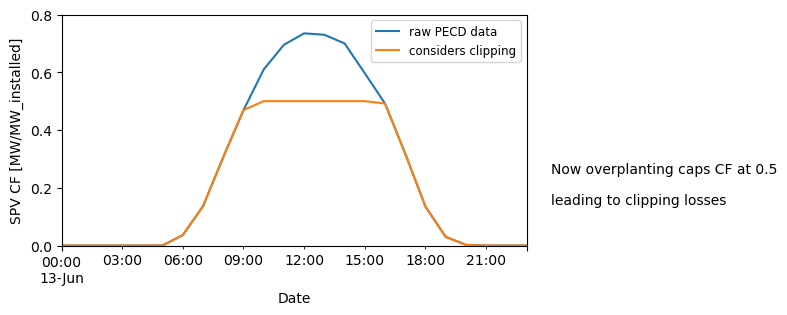

In [7]:
overplanting2 = 2
ic_dc = ic_ac * overplanting2  # GWp, peak DC module capacity

# Using pandas, we can use the clip() functions that defines the min and
# max values for the dataframe
df3 = df2.clip(0, 1 / overplanting2)

ax1 = df2["2020-06-13"].plot(figsize=(6, 3))
df3["2020-06-13"].plot()

ax1.set_ylim([0, 0.8])
ax1.set_yticks(np.arange(0, 1, 0.2))
ax1.set_ylabel("SPV CF [MW/MW_installed]")
ax1.legend(["raw PECD data", "considers clipping"], fontsize=8.5)

value = round(1 / overplanting2, 2)
textstr = ["Now overplanting caps CF at {}".format(value), "leading to clipping losses"]
for k in range(0, 2):
    plt.text(0.94, 0.35 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

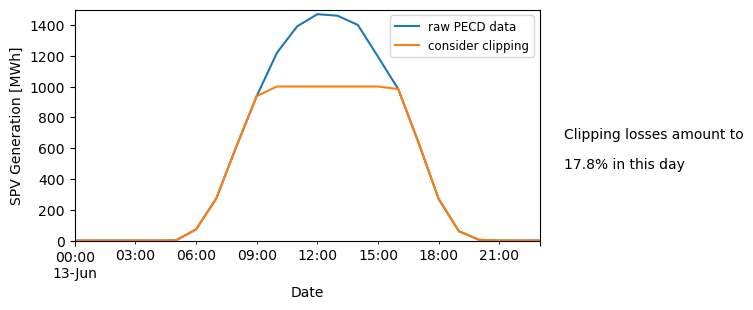

In [8]:
# When we look at this from an energy perspective
ax1 = (df2["2020-06-13"] * ic_dc).plot(figsize=(6, 3))
(df3["2020-06-13"] * ic_dc).plot()

ax1.set_ylim([0, 1500])
ax1.set_ylabel("SPV Generation [MWh]")
ax1.legend(["raw PECD data", "consider clipping"], fontsize=8.5)

temp = (df3["2020-06-13"] * ic_dc).sum() / (df2["2020-06-13"] * ic_dc).sum()
loss = ((1 - temp) * 100).round(1)
textstr = ["Clipping losses amount to", "{}% in this day".format(loss)]
for k in range(0, 2):
    plt.text(0.94, 0.45 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

### Proposing some more structured code to process data

In [9]:
# Converting PECD CF data to PV generation in MWh
def cf_to_energy(cf_in, ic_dc=None, ic_ac=None, overplanting=None):
    if ic_dc is None:
        ener_out = cf_in.clip(0, 1 / overplanting) * ic_ac * overplanting
    elif ic_ac is None:
        ener_out = cf_in.clip(0, 1 / overplanting) * ic_dc
    else:
        ener_out = cf_in.clip(0, ic_ac / ic_dc) * ic_dc
    return ener_out


# Convert measured generation to CF for comparing with PECD. In this case, ideally the PECD
# data should also account for inverter clipping (2nd function below)


def energy_to_cf(ener_in, ic_dc=None, ic_ac=None, overplanting=None):
    if ic_dc is None:
        cf_out = ener_in / (ac_ic * overplanting)
    elif ic_ac is None:
        ener_out = ener_in / ic_dc

    return ener_out, cf_pecd_clip


def add_clip_to_pecd(cf_pecd, ic_dc=None, ic_ac=None, overplanting=None):
    if (dc_ic is None) | (ac_ic is None):
        cf_pecd_clip = cf_pecd.clip(0, 1 / overplanting)
    if overplanting is None:
        cf_pecd_clip = cf_pecd.clip(0, ic_ac, ic_dc)

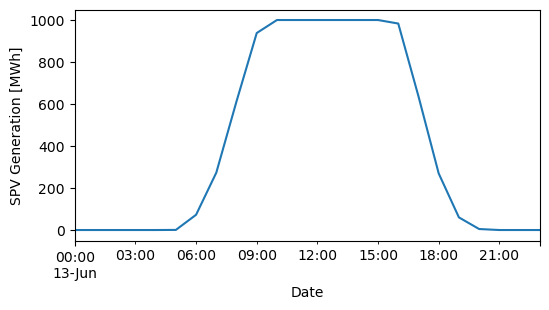

In [10]:
# examples of function being used (all produce same output)
df_gen = cf_to_energy(df2, ic_ac=1000, overplanting=2)
_ = cf_to_energy(df2, ic_dc=2000, overplanting=2)
_ = cf_to_energy(df2, ic_dc=2000, ic_ac=1000)

plt.figure()
ax = df_gen["2020-06-13"].plot(figsize=(6, 3))
ax.set_ylabel("SPV Generation [MWh]")

plt.show()

### Contextual information on overplanting

Public databases containing both AC and DC IC at the individual installation level is not common, despite the high value it can provide for a better use of the PECD data.

In the figure below, we can see histograms of overplanting ratios for different installation sizes in the USA. There is a clear trend for larger installations to consider larger overplanting factors.

![overplanting_histogram](img/overplanting/overplanting_histogram.png)

Overplanting ratio as a function of installation size.
Data source: Tracking The Sun Initiative, LBNL

This data supported our tentative value range, which we recap here:
- residential rooftop: 1.05-1.1
- industrial rooftop: 1.15-1.2
- utility fixed and tracking: 1.2-1.35

However, it is important to have in mind that overplanting practices depend on the engineering and grid practices, which change in time and space. For example, in the USA, there is a trend of an increasing overplanting when designing PV projects.

![overplanting_trends](img/overplanting/overplanting_trends.png)

Source: U.S. Energy Information Administration (eia)

## Take home messages 📌

*  When handling PECD, it is really important to consider DC-level IC data. When such data is unavailable, an estimate is needed, otherwise there is a mismatchin when converting CF or generation data. Typical values are here provided.
*  Clipping losses also take place, although ERA5's native resolution is not ideal to fully account for this. This will be looked in more detail during the next service contract.
*  The degree of overplanting varies from generator to generator, however trends can be found for specific size ranges. However, these trends can change in time and space.
*  There is great value on TSOs collecting both AC and DC IC from generators.